# Загрузка входных файлов

In [1]:
import pandas as pd
import numpy as np

# Путь к папке с исходными данными
# ВАЖНО:
# ноутбук лежит в папке notebooks/,
# поэтому используем ../data/
DATA_PATH = "../data/"

In [2]:
# Описываем входные файлы в виде словаря
# Это удобно, потому что:
# - можно легко добавлять/убирать файлы
# - код не ломается, если файлов станет больше или меньше

files = {
    "transactions": "transactions.csv",      # основной файл с событиями
    "gender_train": "gender_train.csv",      # файл с целевой переменной (если есть)
    "tr_mcc_codes": "tr_mcc_codes.csv",          # справочник MCC-кодов
    "tr_types": "tr_types.csv",               # справочник типов операций
}

# Если на соревнованиях будут другие файлы,
# они просто добавляются в этот словарь

In [3]:
# Загружаем все файлы в DataFrame
dfs = {}

for name, filename in files.items():
    path = DATA_PATH + filename
    try:
        dfs[name] = pd.read_csv(path)
        print(f"[OK] {name}: {dfs[name].shape}")
    except Exception as e:
        print(f"[ERROR] {name}: не удалось загрузить файл")
        print(e)

[OK] transactions: (6849346, 6)
[OK] gender_train: (8400, 2)
[ERROR] tr_mcc_codes: не удалось загрузить файл
Error tokenizing data. C error: Expected 1 fields in line 3, saw 3

[OK] tr_types: (155, 1)


In [4]:
# Быстро смотрим первые строки каждой таблицы
for name, df in dfs.items():
    print(f"\n--- {name} ---")
    display(df.head())


--- transactions ---


,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id
0,39026145,0 10:23:26,4814,1030,-2245.92,NaN
1,39026145,1 10:19:29,6011,7010,56147.89,NaN
2,39026145,1 10:20:56,4829,2330,-56147.89,NaN
3,39026145,1 10:39:54,5499,1010,-1392.47,NaN
4,39026145,2 15:33:42,5499,1010,-920.83,NaN



--- gender_train ---


,customer_id,gender
0,10928546,1
1,69348468,1
2,61009479,0
3,74045822,0
4,27979606,1



--- tr_types ---


,tr_type;tr_description
0,3200;Плата за предоставление услуг посредством...
1,3210;Плата за предоставление отчета по счету к...
2,3800;Плата за обслуживание банковской карты (з...
3,4000;Плата за получение наличных в Сбербанке
4,4001;Плата за получение наличных в Сбербанке (...


In [5]:
# Файл tr_mcc_codes.csv имеет нестандартный разделитель (;),
# поэтому при загрузке явно указываем параметр sep
pd.read_csv(DATA_PATH + "tr_mcc_codes.csv", sep=";").head()

,mcc_code,mcc_description
0,742,Ветеринарные услуги
1,1711,"Генеральные подрядчики по вентиляции, теплосна..."
2,1731,Подрядчики по электричеству
3,1799,"Подрядчики, специализированная торговля — нигд..."
4,2741,Разнообразные издательства/печатное дело


1.1 Загрузка данных
Разработайте агента, автоматически загружающего файлы, указанным в задании. Все данные должны сохраняться в базе данных. Обеспечьте поддержку актуальности базы данных на протяжении всей работы. При повторном запуске агент должен обновлять или дополнять информацию, избегая дублирования.


# Модуль A — 1.1 Загрузка данных в БД (SQLite)

## Цель задания (что проверяют)
Нужно реализовать загрузку входных файлов в базу данных SQLite так, чтобы:
1) Все данные оказались в БД (а не только в памяти pandas)
2) При повторном запуске загрузки НЕ появлялись дубликаты:
   - справочники и таргет обновляются по ключу (upsert)
   - большая таблица событий дополняется без дублей

## Что будет универсальным в шаблоне (что можно менять под другие данные)
В этом блоке мы заранее выделяем параметры, которые могут отличаться на соревнованиях:
- Путь к папке с данными (например `../data/` или `./input/`)
- Название файла базы и путь (например `../db/app.db`)
- Список входных файлов и их назначение (основной / таргет / справочник)
- Разделитель CSV (`,`, `;`, `\t`) и кодировка (`utf-8`, `cp1251`)
- Ключевые поля для таблиц (например `customer_id`, `mcc_code`, `tr_type`)

## План выполнения 1.1 (по шагам)
Шаг 1) Задать универсальные настройки (пути, список файлов, параметры чтения)
Шаг 2) Подключиться к SQLite и создать таблицы
Шаг 3) Загрузить справочники + таргет (upsert по ключу)
Шаг 4) Загрузить транзакции без дублей (через UNIQUE row_hash)
Шаг 5) Проверить, что повторный запуск не дублирует строки

# Настройки (универсальный шаблон)

In [6]:
import os
import sqlite3
import pandas as pd
import hashlib

# =========================
# 1) НАСТРОЙКИ ПРОЕКТА
# =========================

DATA_PATH = "../data/"          # <-- МЕНЯТЬ ПОД ДРУГИЕ ДАННЫЕ (где лежат входные файлы)
DB_DIR = "../db"                # <-- МЕНЯТЬ ПОД ДРУГИЕ ДАННЫЕ (куда сохранять базу)
DB_NAME = "app.db"              # <-- МЕНЯТЬ ПОД ДРУГИЕ ДАННЫЕ (имя файла базы)

DB_PATH = os.path.join(DB_DIR, DB_NAME)  # <-- обычно не меняем

# =========================
# 2) ОПИСАНИЕ ФАЙЛОВ (что загружаем)
# =========================
# Здесь ты на соревнованиях быстро адаптируешься:
# - меняешь имена файлов
# - меняешь sep/encoding если надо

FILES = {
    # Основная таблица событий (большая)
    "transactions": {
        "filename": "transactions.csv",    # <-- МЕНЯТЬ ПОД ДРУГИЕ ДАННЫЕ
        "sep": ",",                        # <-- МЕНЯТЬ (если ; или \t)
        "encoding": "utf-8",               # <-- МЕНЯТЬ (если cp1251)
        "type": "events"                   # <-- обычно не меняем
    },

    # Таблица с таргетом (который предсказываем)
    "gender_train": {
        "filename": "gender_train.csv",    # <-- МЕНЯТЬ ПОД ДРУГИЕ ДАННЫЕ
        "sep": ",",
        "encoding": "utf-8",
        "type": "keyed",                   # <-- обычно не меняем
        "key": "customer_id"               # <-- МЕНЯТЬ, если ключ другой
    },

    # Справочник MCC
    "mcc_codes": {
        "filename": "tr_mcc_codes.csv",    # <-- МЕНЯТЬ ПОД ДРУГИЕ ДАННЫЕ
        "sep": ";",                        # <-- у тебя сейчас ;
        "encoding": "utf-8",
        "type": "keyed",
        "key": "mcc_code"                  # <-- МЕНЯТЬ, если ключ другой
    },

    # Справочник типов транзакций
    "tr_types": {
        "filename": "tr_types.csv",        # <-- МЕНЯТЬ ПОД ДРУГИЕ ДАННЫЕ
        "sep": ";",                        # <-- часто ;
        "encoding": "utf-8",
        "type": "keyed",
        "key": "tr_type"                   # <-- МЕНЯТЬ, если ключ другой
    },
}

# =========================
# 3) ПОДГОТОВКА ПАПКИ db/ и ПОДКЛЮЧЕНИЕ К SQLite
# =========================

os.makedirs(DB_DIR, exist_ok=True)         # <-- обычно не меняем
con = sqlite3.connect(DB_PATH)             # <-- обычно не меняем
cur = con.cursor()                         # <-- обычно не меняем

print("[OK] DATA_PATH =", DATA_PATH)
print("[OK] DB_PATH    =", DB_PATH)
print("[OK] Files configured:", ", ".join(FILES.keys()))

[OK] DATA_PATH = ../data/
[OK] DB_PATH    = ../db/app.db
[OK] Files configured: transactions, gender_train, mcc_codes, tr_types


# Создание таблиц в БД (универсальный минимум)

In [7]:
# =========================
# ЯЧЕЙКА 3 — СОЗДАЕМ ТАБЛИЦЫ В БД
# =========================

# (обычно не меняем) включаем поддержку внешних ключей на будущее
cur.execute("PRAGMA foreign_keys = ON;")

# --- Таблицы "по ключу" (справочники и таргет) ---
# Здесь можно менять названия таблиц и ключевые поля под другие данные

# 1) mcc_codes: ключ mcc_code
cur.execute("""
CREATE TABLE IF NOT EXISTS mcc_codes (
    mcc_code INTEGER PRIMARY KEY,      -- <-- МЕНЯТЬ (если ключ другой / не INTEGER)
    mcc_description TEXT               -- <-- МЕНЯТЬ (если поле называется иначе)
);
""")

# 2) tr_types: ключ tr_type
cur.execute("""
CREATE TABLE IF NOT EXISTS tr_types (
    tr_type INTEGER PRIMARY KEY,       -- <-- МЕНЯТЬ (если ключ другой)
    tr_description TEXT                -- <-- МЕНЯТЬ (если поле называется иначе)
);
""")

# 3) gender_train: ключ customer_id
cur.execute("""
CREATE TABLE IF NOT EXISTS gender_train (
    customer_id INTEGER PRIMARY KEY,   -- <-- МЕНЯТЬ (если ключ другой)
    gender INTEGER                     -- <-- МЕНЯТЬ (если таргет другой: label/target/...)
);
""")

# --- Таблица "событий" (большая) ---
# Главная защита от дублей: row_hash UNIQUE
# Если на соревновании будет явный transaction_id — можно вместо row_hash сделать UNIQUE на transaction_id.

cur.execute("""
CREATE TABLE IF NOT EXISTS transactions (
    customer_id INTEGER,               -- <-- МЕНЯТЬ под структуру файла
    tr_datetime TEXT,                  -- <-- МЕНЯТЬ (может быть datetime)
    mcc_code INTEGER,                  -- <-- МЕНЯТЬ
    tr_type INTEGER,                   -- <-- МЕНЯТЬ
    amount REAL,                       -- <-- МЕНЯТЬ (int/real)
    term_id TEXT,                      -- <-- МЕНЯТЬ (может отсутствовать)
    row_hash TEXT UNIQUE               -- <-- обычно не меняем (универсальная защита от дублей)
);
""")

con.commit()
print("[OK] Tables created/checked in SQLite")

[OK] Tables created/checked in SQLite


# Проверяем, что файлы читаются (универсально)

In [8]:
# =========================
# ЯЧЕЙКА 4 — ЧТЕНИЕ ФАЙЛОВ + ДИАГНОСТИКА
# =========================

def read_csv_universal(path, sep=",", encoding="utf-8"):
    """
    Универсальное чтение CSV.
    Если ошибка (кодировка/разделитель) — сразу видно.
    """
    return pd.read_csv(path, sep=sep, encoding=encoding)

dfs = {}  # сюда сложим датафреймы для дальнейшей загрузки

for table_name, cfg in FILES.items():
    file_path = os.path.join(DATA_PATH, cfg["filename"])

    # 1) Проверяем, что файл вообще существует
    if not os.path.exists(file_path):
        print(f"[ERROR] File not found: {file_path}")
        continue

    # 2) Пробуем прочитать
    try:
        df = read_csv_universal(file_path, sep=cfg["sep"], encoding=cfg["encoding"])
        dfs[table_name] = df

        # 3) Короткая диагностика (важно для соревнований)
        print(f"\n[OK] {table_name}")
        print(f"     file: {cfg['filename']}")
        print(f"     rows: {len(df):,} | cols: {df.shape[1]}")
        print(f"     columns: {list(df.columns)}")

    except UnicodeDecodeError:
        print(f"\n[ERROR] Encoding problem in {cfg['filename']}")
        print("        попробуй encoding='cp1251' или 'utf-8-sig' в FILES[...]['encoding']")
    except pd.errors.ParserError:
        print(f"\n[ERROR] Separator/format problem in {cfg['filename']}")
        print("        попробуй sep=';' или sep='\\t' в FILES[...]['sep']")
    except Exception as e:
        print(f"\n[ERROR] Cannot read {cfg['filename']}: {e}")


[OK] transactions
     file: transactions.csv
     rows: 6,849,346 | cols: 6
     columns: ['customer_id', 'tr_datetime', 'mcc_code', 'tr_type', 'amount', 'term_id']

[OK] gender_train
     file: gender_train.csv
     rows: 8,400 | cols: 2
     columns: ['customer_id', 'gender']

[OK] mcc_codes
     file: tr_mcc_codes.csv
     rows: 184 | cols: 2
     columns: ['mcc_code', 'mcc_description']

[OK] tr_types
     file: tr_types.csv
     rows: 155 | cols: 2
     columns: ['tr_type', 'tr_description']


# Загрузка “keyed” таблиц (upsert без дублей)

In [9]:
# =========================
# ЯЧЕЙКА 5 — UPSERT ДЛЯ СПРАВОЧНИКОВ И ТАРГЕТА
# =========================

def upsert_keyed_table(df: pd.DataFrame, table_name: str, key_col: str):
    """
    Универсальная загрузка таблиц 'по ключу' (справочники, таргет).
    Повторный запуск:
    - если ключ уже есть -> строка обновится
    - если ключа нет -> строка добавится
    """
    # На всякий случай удалим дубли по ключу внутри самого CSV
    # (иногда в исходных данных бывают повторяющиеся ключи)
    df = df.drop_duplicates(subset=[key_col]).copy()

    cols = list(df.columns)
    non_key_cols = [c for c in cols if c != key_col]

    placeholders = ", ".join(["?"] * len(cols))
    cols_sql = ", ".join(cols)

    # SQLite UPSERT
    if non_key_cols:
        update_sql = ", ".join([f"{c}=excluded.{c}" for c in non_key_cols])
        sql = f"""
        INSERT INTO {table_name} ({cols_sql})
        VALUES ({placeholders})
        ON CONFLICT({key_col}) DO UPDATE SET {update_sql};
        """
    else:
        sql = f"""
        INSERT INTO {table_name} ({cols_sql})
        VALUES ({placeholders})
        ON CONFLICT({key_col}) DO NOTHING;
        """

    cur.executemany(sql, df[cols].itertuples(index=False, name=None))
    con.commit()

    print(f"[OK] upsert -> {table_name}: {len(df):,} rows (key={key_col})")


# --- Загружаем все таблицы типа "keyed" из FILES ---
for table_name, cfg in FILES.items():
    if cfg["type"] != "keyed":
        continue

    df = dfs[table_name]              # уже прочитали на шаге проверки
    key = cfg["key"]                  # ключ берём из конфигурации

    # Универсальность: если на соревнованиях ключ/таблица другие — правим только FILES
    upsert_keyed_table(df, table_name, key)

print("[DONE] All keyed tables loaded")

[OK] upsert -> gender_train: 8,400 rows (key=customer_id)
[OK] upsert -> mcc_codes: 184 rows (key=mcc_code)
[OK] upsert -> tr_types: 155 rows (key=tr_type)
[DONE] All keyed tables loaded


In [10]:
# =========================
# ЯЧЕЙКА X — ЗАГРУЗКА БОЛЬШОЙ ТАБЛИЦЫ БЕЗ ID (transactions и т.п.)
# Принцип: читаем чанками -> считаем row_hash -> INSERT OR IGNORE
# =========================

# ---------- НАСТРОЙКИ (чаще всего это менять на соревнованиях) ----------
EVENT_TABLE = "transactions"                 # <-- МЕНЯТЬ (если таблица называется иначе)
EVENT_FILENAME = FILES[EVENT_TABLE]["filename"]  # <-- обычно не меняем (берём из FILES)
EVENT_SEP = FILES[EVENT_TABLE]["sep"]        # <-- обычно не меняем
EVENT_ENCODING = FILES[EVENT_TABLE]["encoding"]  # <-- обычно не меняем

CHUNKSIZE = 200_000                          # <-- МЕНЯТЬ (50_000 / 100_000 / 300_000)
# Колонки, по которым строим уникальность события:
HASH_COLS = ["customer_id", "tr_datetime", "mcc_code", "tr_type", "amount", "term_id"]
# <-- МЕНЯТЬ, если в другой задаче другие колонки / другое имя столбцов
# Важно: hash должен считаться по тем полям, которые полностью описывают "одно событие".


# ---------- ВСПОМОГАТЕЛЬНОЕ (обычно не меняем) ----------
event_path = os.path.join(DATA_PATH, EVENT_FILENAME)
if not os.path.exists(event_path):
    raise FileNotFoundError(f"Не найден файл: {event_path}")

def add_row_hash(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    """
    Добавляет технический уникальный ключ row_hash.
    Одинаковая строка -> одинаковый hash -> защита от дублей.
    """
    # Приводим NaN к пустой строке и всё к строкам (чтобы hash был стабильным)
    tmp = df[cols].copy()
    tmp = tmp.fillna("").astype(str)

    # Быстрый "псевдо-хеш" от pandas -> превращаем в hex-строку (стабильно внутри одного запуска/загрузки)
    # Обычно этого достаточно для задач соревнований.
    h = pd.util.hash_pandas_object(tmp, index=False).astype("uint64")
    df["row_hash"] = h.map(lambda x: f"{x:016x}")  # 16 hex символов
    return df

def insert_ignore_chunk(df: pd.DataFrame, table_name: str):
    """
    Вставка чанка в SQLite без дублей.
    Дубли отсечёт UNIQUE(row_hash) через INSERT OR IGNORE.
    """
    cols = list(df.columns)
    cols_sql = ", ".join(cols)
    placeholders = ", ".join(["?"] * len(cols))
    sql = f"INSERT OR IGNORE INTO {table_name} ({cols_sql}) VALUES ({placeholders});"

    cur.executemany(sql, df[cols].itertuples(index=False, name=None))
    con.commit()


# ---------- ОСНОВНОЙ ЦИКЛ ЗАГРУЗКИ (обычно не меняем) ----------
total_insert_attempts = 0

for i, chunk in enumerate(pd.read_csv(event_path, sep=EVENT_SEP, encoding=EVENT_ENCODING, chunksize=CHUNKSIZE), start=1):
    # 1) Подготовка: убедимся, что нужные колонки для hash есть
    missing = [c for c in HASH_COLS if c not in chunk.columns]
    if missing:
        raise ValueError(
            f"В чанке нет колонок {missing}. "
            f"Проверь HASH_COLS и названия столбцов в файле {EVENT_FILENAME}"
        )

    # 2) Добавляем row_hash
    chunk = add_row_hash(chunk, HASH_COLS)

    # 3) Вставка без дублей
    insert_ignore_chunk(chunk, EVENT_TABLE)

    total_insert_attempts += len(chunk)

    # 4) Прогресс (удобно на соревнованиях)
    if i == 1 or i % 10 == 0:
        print(f"[OK] chunk {i}: processed {len(chunk):,} rows | total processed {total_insert_attempts:,}")

print("[DONE] Event table loaded with row_hash + INSERT OR IGNORE")

[OK] chunk 1: processed 200,000 rows | total processed 200,000
[OK] chunk 10: processed 200,000 rows | total processed 2,000,000
[OK] chunk 20: processed 200,000 rows | total processed 4,000,000
[OK] chunk 30: processed 200,000 rows | total processed 6,000,000
[DONE] Event table loaded with row_hash + INSERT OR IGNORE


In [11]:
# Проверка таблицы
cur.execute("SELECT COUNT(*) FROM transactions;").fetchone()

(6826527,)

In [12]:
#  Проверить, что hash уникален
cur.execute("""
SELECT COUNT(*) - COUNT(DISTINCT row_hash)
FROM transactions;
""").fetchone()

(0,)

1.2 Предобработка данных и выделение значимых атрибутов
Провести анализ атрибутов, влияющих на определение пола клиента. Определите наиболее значимые признаки с использованием методов статистического анализа или методов оценки важности признаков. 

In [13]:
# =========================
# 1.2 — ЯЧЕЙКА 1 (Code)
# Цель ячейки: собрать "рабочий датасет" для анализа важности признаков
# (таргет + события)
# =========================

import sqlite3
import pandas as pd

# --- НАСТРОЙКИ (это чаще всего меняют на соревнованиях) ---
DB_PATH = "../db/app.db"                 # <-- МЕНЯТЬ: путь/имя базы, если другое

TARGET_TABLE = "gender_train"            # <-- МЕНЯТЬ: таблица с таргетом (label/target/...)
TARGET_COL = "gender"                    # <-- МЕНЯТЬ: имя таргета (label/target/class/...)

EVENTS_TABLE = "transactions"            # <-- МЕНЯТЬ: таблица событий (events/logs/transactions/...)
ID_COL = "customer_id"                   # <-- МЕНЯТЬ: общий ключ (client_id/user_id/customer_id)

# Колонки, которые берём из событий (минимум для старта)
EVENT_COLS = ["tr_datetime", "mcc_code", "tr_type", "amount", "term_id"]  # <-- МЕНЯТЬ под датасет

# Ограничение по строкам для быстрой отладки (на больших данных удобно)
DEBUG_LIMIT = None   # <-- МЕНЯТЬ: например 2_000_000 для ускорения, либо None чтобы грузить всё

# --- ПОДКЛЮЧЕНИЕ К БД (обычно не меняем) ---
con = sqlite3.connect(DB_PATH)

# 1) Читаем таргет
df_target = pd.read_sql_query(
    f"SELECT {ID_COL}, {TARGET_COL} FROM {TARGET_TABLE};",
    con
)

print("[OK] target loaded:", df_target.shape)
display(df_target.head())

# 2) Читаем события только для клиентов, которые есть в таргете
#    (это ускоряет и логически правильно: анализируем влияние признаков на таргет)
event_cols_sql = ", ".join([ID_COL] + EVENT_COLS)

sql_events = f"""
SELECT e.{event_cols_sql}
FROM {EVENTS_TABLE} e
INNER JOIN {TARGET_TABLE} t
ON e.{ID_COL} = t.{ID_COL}
"""

# (опционально) limit для быстрой отладки
if DEBUG_LIMIT is not None:
    sql_events += f"\nLIMIT {int(DEBUG_LIMIT)}"

df_events = pd.read_sql_query(sql_events, con)

print("[OK] events (only labeled customers) loaded:", df_events.shape)
display(df_events.head())

# 3) Объединяем события + таргет в одну таблицу
df = df_events.merge(df_target, on=ID_COL, how="inner")

print("[OK] merged dataset:", df.shape)
print("[OK] target distribution:")
display(df[TARGET_COL].value_counts(dropna=False))

# 4) Базовая чистка типов (обычно не меняем, но иногда подстраивают под формат)
# amount -> float
if "amount" in df.columns:
    df["amount"] = pd.to_numeric(df["amount"], errors="coerce")

# 5) Мини-фичи из даты/времени (универсально, но формат даты может быть разный!)
# В твоём датасете tr_datetime похоже на "день_номер HH:MM:SS" (например "0 10:23:26")
# На соревнованиях может быть полноценный timestamp — тогда будем парсить иначе.
if "tr_datetime" in df.columns:
    # безопасное извлечение "часа" даже при странном формате
    # если формат "YYYY-MM-DD ..." — тоже обычно сработает через split
    time_part = df["tr_datetime"].astype(str).str.split().str[-1]   # берём последнюю часть
    df["hour"] = pd.to_numeric(time_part.str.split(":").str[0], errors="coerce")

# 6) Быстрая диагностика (полезно всегда)
print("\n[DIAG] missing values top:")
display(df.isna().mean().sort_values(ascending=False).head(10))

con.close()

# Итог ячейки:
# df = события клиентов с известным таргетом + базовые чистки/час
# На этом шаге мы:
# 1) взяли клиентов с известным таргетом (gender_train)
# 2) выбрали их транзакции из основной таблицы событий
# 3) соединили события и таргет по customer_id
# В результате получили рабочий датасет (df),
# где каждая строка — это событие клиента + его таргет.
# Этот датасет используется для анализа значимых признаков.

[OK] target loaded: (8400, 2)


,customer_id,gender
0,22899,1
1,28753,0
2,42096,0
3,49793,1
4,50940,0


[OK] events (only labeled customers) loaded: (3738548, 6)


,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id
0,39026145,0 10:23:26,4814,1030,-2245.92,None
1,39026145,1 10:19:29,6011,7010,56147.89,None
2,39026145,1 10:20:56,4829,2330,-56147.89,None
3,39026145,1 10:39:54,5499,1010,-1392.47,None
4,39026145,2 15:33:42,5499,1010,-920.83,None


[OK] merged dataset: (3738548, 7)
[OK] target distribution:


gender
0    1957910
1    1780638
Name: count, dtype: int64


[DIAG] missing values top:


term_id        0.404408
customer_id    0.000000
tr_datetime    0.000000
mcc_code       0.000000
tr_type        0.000000
amount         0.000000
gender         0.000000
hour           0.000000
dtype: float64

In [14]:
# =========================
# 1.2 — ЯЧЕЙКА 2 (Code)
# Цель: построить признаки на уровне клиента (customer_id)
# Вход: df (события + таргет) из ЯЧЕЙКИ 1
# Выход: df_clients (8400 строк) = признаки клиента + gender
# =========================

import pandas as pd
import numpy as np

# ---------- НАСТРОЙКИ (чаще всего меняют на соревнованиях) ----------
ID_COL = "customer_id"          # <-- МЕНЯТЬ: общий ключ (user_id/client_id/...)
TARGET_COL = "gender"           # <-- МЕНЯТЬ: таргет (label/target/class/...)

AMOUNT_COL = "amount"           # <-- МЕНЯТЬ: колонка суммы (amount/value/price/...)
HOUR_COL = "hour"               # <-- МЕНЯТЬ: если час называется иначе или ты его не создавал
MCC_COL = "mcc_code"            # <-- МЕНЯТЬ: категория расходов (category_id/mcc/...)
TYPE_COL = "tr_type"            # <-- МЕНЯТЬ: тип операции (type_id/event_type/...)

# Если в другом датасете нет term_id — просто отключишь блок ниже
TERM_COL = "term_id"            # <-- МЕНЯТЬ: терминал/точка/устройство (pos_id/terminal_id/...)

# ---------- 0) защитные проверки (обычно не меняем) ----------
needed = [ID_COL, TARGET_COL, AMOUNT_COL]
missing = [c for c in needed if c not in df.columns]
if missing:
    raise ValueError(f"В df нет колонок {missing}. Проверь названия ID/TARGET/AMOUNT.")

# ---------- 1) базовые признаки по сумме и количеству (универсально) ----------
# Важно: делаем признаки на уровне клиента, иначе будет смещение (у кого больше транзакций, тот важнее)
g = df.groupby(ID_COL)

feat_base = g[AMOUNT_COL].agg(
    tx_count="count",          # сколько транзакций
    amount_sum="sum",          # общий оборот (с учётом знака)
    amount_mean="mean",        # средний чек
    amount_std="std",          # разброс
    amount_min="min",
    amount_max="max",
).reset_index()

# Дополнительно: расходы/поступления отдельно (очень полезно и универсально)
# В транзакциях часто: расход < 0, поступление > 0
df["_is_spend"] = (df[AMOUNT_COL] < 0).astype(int)       # <-- обычно не меняем
df["_is_income"] = (df[AMOUNT_COL] > 0).astype(int)      # <-- обычно не меняем
df["_spend_abs"] = df[AMOUNT_COL].where(df[AMOUNT_COL] < 0, 0).abs()
df["_income"] = df[AMOUNT_COL].where(df[AMOUNT_COL] > 0, 0)

g2 = df.groupby(ID_COL)

feat_flow = g2[["_is_spend", "_is_income", "_spend_abs", "_income"]].agg(
    spend_count=("_is_spend", "sum"),           # сколько расходов
    income_count=("_is_income", "sum"),         # сколько поступлений
    spend_sum=("_spend_abs", "sum"),            # сколько потратил (по модулю)
    income_sum=("_income", "sum"),              # сколько получил
).reset_index()

# ---------- 2) признаки по времени (если есть hour) ----------
# Это универсально: мужчины/женщины могут отличаться по активности по времени суток
feat_time = None
if HOUR_COL in df.columns:
    # доля операций ночью/утром/днём/вечером — простой и понятный признак для отчёта
    # <-- МЕНЯТЬ: границы можно менять под требования
    bins = [-1, 5, 11, 17, 23]
    labels = ["night", "morning", "day", "evening"]
    df["_hour_bin"] = pd.cut(df[HOUR_COL], bins=bins, labels=labels)

    tmp = (df.groupby([ID_COL, "_hour_bin"], observed=True).size().unstack(fill_value=0))

    # переводим в доли (чтобы сравнение было честным)
    tmp = tmp.div(tmp.sum(axis=1), axis=0)

    # переименуем колонки красиво
    tmp = tmp.add_prefix("share_")
    tmp.reset_index(inplace=True)
    feat_time = tmp

# ---------- 3) признаки по категориям (MCC) ----------
# Идея: сколько уникальных категорий, топовые категории, доли категорий
feat_mcc = None
if MCC_COL in df.columns:
    # 3.1) сколько уникальных mcc у клиента
    uniq_mcc = df.groupby(ID_COL)[MCC_COL].nunique().reset_index(name="mcc_nunique")

    # 3.2) топ-K mcc по частоте (K можно менять)
    TOPK = 10   # <-- МЕНЯТЬ ПОД ДРУГИЕ ДАННЫЕ (5/10/20) — сколько категорий берем
    top_mcc = df[MCC_COL].value_counts().head(TOPK).index.tolist()

    # доли операций в топовых категориях (очень хороший универсальный признак)
    tmp = df[df[MCC_COL].isin(top_mcc)].groupby([ID_COL, MCC_COL]).size().unstack(fill_value=0)
    tmp = tmp.div(tmp.sum(axis=1), axis=0)  # доли внутри клиента

    # переименуем колонки
    tmp.columns = [f"share_mcc_{c}" for c in tmp.columns]
    tmp.reset_index(inplace=True)

    feat_mcc = uniq_mcc.merge(tmp, on=ID_COL, how="left").fillna(0)

# ---------- 4) признаки по типам операций (tr_type) ----------
feat_type = None
if TYPE_COL in df.columns:
    # уникальные типы
    uniq_type = df.groupby(ID_COL)[TYPE_COL].nunique().reset_index(name="tr_type_nunique")

    # топ-K типов по частоте
    TOPK_TYPE = 10  # <-- МЕНЯТЬ (5/10/20)
    top_types = df[TYPE_COL].value_counts().head(TOPK_TYPE).index.tolist()

    tmp = df[df[TYPE_COL].isin(top_types)].groupby([ID_COL, TYPE_COL]).size().unstack(fill_value=0)
    tmp = tmp.div(tmp.sum(axis=1), axis=0)

    tmp.columns = [f"share_type_{c}" for c in tmp.columns]
    tmp.reset_index(inplace=True)

    feat_type = uniq_type.merge(tmp, on=ID_COL, how="left").fillna(0)

# ---------- 5) признаки по терминалу (term_id) — если есть ----------
feat_term = None
if TERM_COL in df.columns:
    # доля заполненных term_id + сколько уникальных терминалов
    tmp = df.groupby(ID_COL)[TERM_COL].agg(
        term_filled_share=lambda x: x.notna().mean(),
        term_nunique=lambda x: x.nunique(dropna=True)
    ).reset_index()
    feat_term = tmp

# ---------- 6) собираем всё в одну таблицу признаков ----------
df_clients = feat_base.merge(feat_flow, on=ID_COL, how="left")

if feat_time is not None:
    df_clients = df_clients.merge(feat_time, on=ID_COL, how="left")
if feat_mcc is not None:
    df_clients = df_clients.merge(feat_mcc, on=ID_COL, how="left")
if feat_type is not None:
    df_clients = df_clients.merge(feat_type, on=ID_COL, how="left")
if feat_term is not None:
    df_clients = df_clients.merge(feat_term, on=ID_COL, how="left")

# таргет добавляем в конец (чтобы было удобно анализировать)
df_clients = df_clients.merge(
    df[[ID_COL, TARGET_COL]].drop_duplicates(),
    on=ID_COL,
    how="inner"
)

# ---------- 7) финальная диагностика ----------
print("[OK] df_clients shape:", df_clients.shape)
display(df_clients.head())

print("\n[OK] missing values (top):")
display(df_clients.isna().mean().sort_values(ascending=False).head(15))

print("\n[OK] target distribution (clients):")
display(df_clients[TARGET_COL].value_counts(dropna=False))

# На выходе:
# df_clients — готовая таблица признаков клиентов для:
# - статистического сравнения полов
# - оценки важности признаков через модель

[OK] df_clients shape: (8400, 40)


,customer_id,tx_count,amount_sum,amount_mean,amount_std,amount_min,amount_max,spend_count,income_count,spend_sum,...,share_type_1110,share_type_1200,share_type_2010,share_type_2370,share_type_7010,share_type_7030,share_type_7070,term_filled_share,term_nunique,gender
0,22899,234,-629796.59,-2691.438419,127851.642622,-868607.92,875907.15,166,68,6448719.64,...,0.134328,0.004975,0.238806,0.054726,0.199005,0.059701,0.044776,0.619658,57,1
1,28753,294,-26546282.86,-90293.479116,785586.199773,-3244539.76,3099363.77,244,50,72253691.83,...,0.252918,0.000000,0.093385,0.011673,0.019455,0.112840,0.054475,0.387755,52,0
2,42096,935,-5527179.56,-5911.421989,63673.134792,-337785.73,673774.73,869,66,16141518.18,...,0.112619,0.000000,0.249661,0.001357,0.002714,0.027137,0.006784,0.479144,138,0
3,49793,513,-24529283.63,-47815.367700,161784.403694,-673774.73,112295.79,488,25,25142418.66,...,0.083168,0.000000,0.138614,0.000000,0.023762,0.000000,0.025743,0.547758,90,1
4,50940,118,-1709747.26,-14489.383559,18341.188346,-110049.87,4491.83,106,12,1763649.22,...,0.051282,0.000000,0.769231,0.000000,0.000000,0.000000,0.102564,0.635593,32,0



[OK] missing values (top):


amount_std         0.000714
customer_id        0.000000
share_type_1110    0.000000
share_mcc_5912     0.000000
share_mcc_6010     0.000000
share_mcc_6011     0.000000
tr_type_nunique    0.000000
share_type_1010    0.000000
share_type_1030    0.000000
share_type_1100    0.000000
share_type_1200    0.000000
share_mcc_5541     0.000000
share_type_2010    0.000000
share_type_2370    0.000000
share_type_7010    0.000000
dtype: float64


[OK] target distribution (clients):


gender
0    4687
1    3713
Name: count, dtype: int64

In [15]:
# =========================
# 1.2 — ЯЧЕЙКА 3 (Code)
# Цель: найти значимые признаки (статистика + важность модели)
# Вход: df_clients из ЯЧЕЙКИ 2
# Выход:
#   - feat_report: таблица значимости признаков
#   - TOP_FEATURES: список лучших признаков
# =========================

import numpy as np
import pandas as pd

# ---------- НАСТРОЙКИ (чаще всего меняют на соревнованиях) ----------
ID_COL = "customer_id"      # <-- МЕНЯТЬ: ключ объекта
TARGET_COL = "gender"       # <-- МЕНЯТЬ: таргет (label/target/class/...)
TOP_N = 20                  # <-- МЕНЯТЬ: сколько лучших признаков вывести

# (обычно не меняем) — убираем ID и target из признаков
feature_cols = [c for c in df_clients.columns if c not in [ID_COL, TARGET_COL]]

# ---------- 0) защитные проверки (обычно не меняем) ----------
if TARGET_COL not in df_clients.columns:
    raise ValueError(f"Нет таргета {TARGET_COL} в df_clients")

# оставляем только числовые признаки (универсально для большинства ML)
X = df_clients[feature_cols].select_dtypes(include=[np.number]).copy()
y = df_clients[TARGET_COL].copy()

print("[OK] X shape:", X.shape, "| y shape:", y.shape)

# Важно: после агрегации могут быть NaN (например std, если 1 транзакция)
# Заполняем безопасно: медианой по колонке (универсально)
X = X.fillna(X.median(numeric_only=True))

# =========================
# A) БЫСТРАЯ СТАТИСТИКА (для отчёта)
# =========================
# Идея:
# - сравнить средние значения признаков у классов 0 и 1
# - посчитать эффект (difference) и "насколько сильно" (effect size)
#
# Это универсально: работает в бинарной классификации почти всегда.

def cohens_d(a, b):
    """Эффект Коэна d (насколько отличаются группы). Чем больше |d| — тем сильнее признак."""
    a = np.asarray(a); b = np.asarray(b)
    if len(a) < 2 or len(b) < 2:
        return np.nan
    sa = np.var(a, ddof=1); sb = np.var(b, ddof=1)
    pooled = np.sqrt((sa + sb) / 2)
    if pooled == 0:
        return 0.0
    return (np.mean(a) - np.mean(b)) / pooled

# Разделяем по классам
X0 = X[y == 0]
X1 = X[y == 1]

rows = []
for col in X.columns:
    mean0 = X0[col].mean()
    mean1 = X1[col].mean()
    d = cohens_d(X0[col], X1[col])      # эффект
    diff = mean1 - mean0                # разница средних
    rows.append((col, mean0, mean1, diff, d))

feat_report = pd.DataFrame(rows, columns=["feature", "mean_class0", "mean_class1", "diff(1-0)", "cohens_d"])
feat_report["abs_d"] = feat_report["cohens_d"].abs()

# Топ по силе отличий
feat_report = feat_report.sort_values("abs_d", ascending=False).reset_index(drop=True)

print("\n[OK] Top features by effect size (Cohen's d):")
display(feat_report.head(TOP_N))

# =========================
# B) ВАЖНОСТЬ ЧЕРЕЗ МОДЕЛЬ (самое понятное)
# =========================
# Используем простой RandomForest:
# - не требует масштабирования
# - нормально работает на табличных данных
# - дает feature_importances_
#
# Если на соревновании разрешен CatBoost — можно заменить потом.

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# ---------- НАСТРОЙКИ МОДЕЛИ (можно менять) ----------
TEST_SIZE = 0.2          # <-- МЕНЯТЬ: доля теста
RANDOM_STATE = 42        # <-- обычно не меняем
N_ESTIMATORS = 300       # <-- МЕНЯТЬ: 200/300/500
MAX_DEPTH = None         # <-- МЕНЯТЬ: 6/10/None

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

rf = RandomForestClassifier(
    n_estimators=N_ESTIMATORS,
    random_state=RANDOM_STATE,
    max_depth=MAX_DEPTH,
    n_jobs=-1
)

rf.fit(X_train, y_train)
pred = rf.predict(X_test)
f1 = f1_score(y_test, pred)

print(f"\n[OK] RandomForest F1 (quick check): {f1:.4f}")

imp = pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

print("\n[OK] Top features by model importance:")
display(imp.head(TOP_N))

# Финальный список признаков (для дальнейшего ML)
TOP_FEATURES = imp["feature"].head(TOP_N).tolist()

print("\n[DONE] TOP_FEATURES ready (use in modeling):")
print(TOP_FEATURES)

[OK] X shape: (8400, 38) | y shape: (8400,)

[OK] Top features by effect size (Cohen's d):


,feature,mean_class0,mean_class1,diff(1-0),cohens_d,abs_d
0,share_mcc_5541,1.141617e-02,3.802003e-02,2.660386e-02,-0.551021,0.551021
1,share_mcc_5912,2.782269e-02,1.725555e-02,-1.056714e-02,0.325643,0.325643
2,share_day,4.039521e-01,3.683250e-01,-3.562716e-02,0.273305,0.273305
3,share_night,1.371732e-01,1.685501e-01,3.137687e-02,-0.216670,0.216670
4,share_mcc_4814,2.208518e-01,1.887546e-01,-3.209718e-02,0.187927,0.187927
5,amount_std,1.574010e+05,2.297956e+05,7.239464e+04,-0.175545,0.175545
6,share_type_1110,1.287391e-01,1.513523e-01,2.261316e-02,-0.173150,0.173150
7,share_evening,1.687434e-01,1.905072e-01,2.176378e-02,-0.171801,0.171801
8,share_type_1030,2.110482e-01,1.816656e-01,-2.938262e-02,0.167895,0.167895
9,amount_sum,-7.036140e+06,-1.261739e+07,-5.581251e+06,0.164410,0.164410



[OK] RandomForest F1 (quick check): 0.6377

[OK] Top features by model importance:


,feature,importance
20,share_mcc_5541,0.090223
22,share_mcc_5912,0.052195
12,share_day,0.038220
1,amount_sum,0.036210
8,spend_sum,0.034777
3,amount_std,0.033068
24,share_mcc_6011,0.029372
13,share_evening,0.028844
4,amount_min,0.028482
36,term_filled_share,0.028184



[DONE] TOP_FEATURES ready (use in modeling):
['share_mcc_5541', 'share_mcc_5912', 'share_day', 'amount_sum', 'spend_sum', 'amount_std', 'share_mcc_6011', 'share_evening', 'amount_min', 'term_filled_share', 'share_morning', 'share_mcc_4814', 'amount_mean', 'share_type_1030', 'share_night', 'share_type_2010', 'share_type_1110', 'amount_max', 'spend_count', 'tx_count']


In [16]:
# =========================
# 1.3 — ЯЧЕЙКА 1 (Code)
# Цель: собрать список признаков и сделать "паспорт" столбцов
# Вход: df_clients (таблица признаков клиентов) из задания 1.2
# Выход: data_dict (таблица описаний признаков)
# =========================

import pandas as pd

# ---------- НАСТРОЙКИ (МЕНЯТЬ НА СОРЕВНОВАНИИ) ----------
TARGET_COL = "gender"  # <-- МЕНЯТЬ: target/label/class/...

# какие признаки описываем:
# вариант А: все признаки кроме таргета
FEATURES = [c for c in df_clients.columns if c != TARGET_COL]  # <-- обычно не меняем

# ---------- ШАБЛОН "единиц" по имени признака (УНИВЕРСАЛЬНО) ----------
def guess_units(col: str) -> str:
    c = col.lower()
    if c.startswith("share_"):
        return "доля (0..1)"
    if "count" in c or c.endswith("_nunique"):
        return "кол-во (шт.)"
    if "amount" in c or "sum" in c:
        return "денежная величина (как в данных)"
    if "mean" in c:
        return "среднее значение (как в данных)"
    if "std" in c:
        return "разброс (std), единицы как в данных"
    if "min" in c or "max" in c:
        return "значение (как в данных)"
    if "hour" in c:
        return "час (0..23)"
    return "числовая величина"

# ---------- ШАБЛОН "назначения" (УНИВЕРСАЛЬНО) ----------
def guess_purpose(col: str) -> str:
    c = col.lower()
    if c.startswith("share_mcc_"):
        return "поведение по категориям трат; помогает отличать группы по структуре расходов"
    if c.startswith("share_type_"):
        return "поведение по типам операций; отражает привычки использования финансовых операций"
    if c.startswith("share_") and ("night" in c or "morning" in c or "day" in c or "evening" in c):
        return "временной паттерн активности; полезно для поведенческих различий"
    if "tx_count" in c or "count" in c:
        return "интенсивность активности; сколько событий у объекта"
    if "amount" in c:
        return "финансовый профиль; отражает объёмы/размеры операций"
    if "term" in c:
        return "поведение по точкам/терминалам; стабильность и разнообразие мест операций"
    if "nunique" in c:
        return "разнообразие поведения; сколько разных категорий/типов/точек"
    return "обобщённый поведенческий признак; может давать сигнал модели"

# ---------- СОБИРАЕМ ТАБЛИЦУ ОПИСАНИЙ ----------
rows = []
for col in FEATURES:
    rows.append({
        "attribute": col,
        "meaning (расшифровка)": "TODO: дописать вручную (если нужно точнее)",  # <-- можно быстро дописать топ-20
        "units (ед.)": guess_units(col),
        "purpose (назначение)": guess_purpose(col),
        "dtype": str(df_clients[col].dtype),
        "missing_share": float(df_clients[col].isna().mean()),
    })

data_dict = pd.DataFrame(rows).sort_values(["missing_share", "attribute"], ascending=[False, True]).reset_index(drop=True)

print("[OK] data_dict created:", data_dict.shape)
display(data_dict.head(20))

[OK] data_dict created: (39, 6)


,attribute,meaning (расшифровка),units (ед.),purpose (назначение),dtype,missing_share
0,amount_std,TODO: дописать вручную (если нужно точнее),денежная величина (как в данных),финансовый профиль; отражает объёмы/размеры оп...,float64,0.000714
1,amount_max,TODO: дописать вручную (если нужно точнее),денежная величина (как в данных),финансовый профиль; отражает объёмы/размеры оп...,float64,0.000000
2,amount_mean,TODO: дописать вручную (если нужно точнее),денежная величина (как в данных),финансовый профиль; отражает объёмы/размеры оп...,float64,0.000000
3,amount_min,TODO: дописать вручную (если нужно точнее),денежная величина (как в данных),финансовый профиль; отражает объёмы/размеры оп...,float64,0.000000
4,amount_sum,TODO: дописать вручную (если нужно точнее),денежная величина (как в данных),финансовый профиль; отражает объёмы/размеры оп...,float64,0.000000
5,customer_id,TODO: дописать вручную (если нужно точнее),числовая величина,обобщённый поведенческий признак; может давать...,int64,0.000000
6,income_count,TODO: дописать вручную (если нужно точнее),кол-во (шт.),интенсивность активности; сколько событий у об...,int64,0.000000
7,income_sum,TODO: дописать вручную (если нужно точнее),денежная величина (как в данных),обобщённый поведенческий признак; может давать...,float64,0.000000
8,mcc_nunique,TODO: дописать вручную (если нужно точнее),кол-во (шт.),разнообразие поведения; сколько разных категор...,int64,0.000000
9,share_day,TODO: дописать вручную (если нужно точнее),доля (0..1),временной паттерн активности; полезно для пове...,float64,0.000000


In [17]:
# =========================
# 1.3 — ЯЧЕЙКА 2 (Code)
# Цель: проверить нормальность распределений признаков
# Методы:
#  - графики: hist + QQ
#  - критерии: Shapiro (малые выборки), D’Agostino, Anderson
#  - доп. метрики: skewness/kurtosis
# Выход: normality_report (таблица)
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats

# ---------- НАСТРОЙКИ (МЕНЯТЬ НА СОРЕВНОВАНИИ) ----------
TARGET_COL = "gender"                      # <-- МЕНЯТЬ
MAX_FEATURES_TO_TEST = 20                  # <-- МЕНЯТЬ: сколько признаков проверяем (для отчёта обычно 10–30)
SAMPLE_FOR_TESTS = 5000                    # <-- МЕНЯТЬ: чтобы тесты были адекватны и быстры (2000-10000)
ALPHA = 0.05                               # <-- обычно не меняем (уровень значимости)

# что проверяем: обычно берут TOP_FEATURES + несколько базовых
# если у тебя есть TOP_FEATURES — используй их:
try:
    selected = TOP_FEATURES[:MAX_FEATURES_TO_TEST]
except NameError:
    # fallback: берём первые числовые признаки
    numeric_cols = [c for c in df_clients.columns if c != TARGET_COL and pd.api.types.is_numeric_dtype(df_clients[c])]
    selected = numeric_cols[:MAX_FEATURES_TO_TEST]

print("[OK] Selected features for normality check:", selected)

def recommend_transform(col, series):
    """Простая рекомендация по трансформации по скошенности."""
    s = series.dropna()
    if len(s) < 50:
        return "слишком мало данных для вывода"
    skew = stats.skew(s, nan_policy="omit")
    # очень грубое правило:
    if skew > 1:
        # если есть неотрицательные значения — log1p подходит
        if (s >= 0).all():
            return "сильная правая скошенность → log1p или Yeo-Johnson"
        return "сильная скошенность → Yeo-Johnson"
    if skew < -1:
        return "сильная левая скошенность → Yeo-Johnson / отражение+log (по ситуации)"
    if abs(skew) > 0.5:
        return "умеренная скошенность → Yeo-Johnson / робастное масштабирование"
    return "трансформация не обязательна; можно стандартизировать"

def normality_tests(x):
    """
    Возвращает результаты тестов нормальности.
    Важно: на больших выборках тесты часто отклоняют нормальность почти всегда,
    поэтому мы тестируем на подвыборке SAMPLE_FOR_TESTS.
    """
    x = x.dropna()
    if len(x) > SAMPLE_FOR_TESTS:
        x = x.sample(SAMPLE_FOR_TESTS, random_state=42)

    out = {}
    out["n_used"] = len(x)
    out["skew"] = float(stats.skew(x, nan_policy="omit"))
    out["kurtosis"] = float(stats.kurtosis(x, nan_policy="omit"))

    # Shapiro рекомендован для небольших выборок (до ~5000)
    if len(x) <= 5000:
        sh_stat, sh_p = stats.shapiro(x)
        out["shapiro_p"] = float(sh_p)
    else:
        out["shapiro_p"] = np.nan

    # D’Agostino K^2 — хорошо для n>=20
    if len(x) >= 20:
        dag_stat, dag_p = stats.normaltest(x)
        out["dagostino_p"] = float(dag_p)
    else:
        out["dagostino_p"] = np.nan

    # Anderson-Darling (без p-value, но есть критические значения)
    ad = stats.anderson(x, dist="norm")
    out["anderson_stat"] = float(ad.statistic)
    # сравним с критическим значением на 5%
    # levels: [15,10,5,2.5,1]
    idx_5 = list(ad.significance_level).index(5.0) if 5.0 in ad.significance_level else 2
    out["anderson_crit_5%"] = float(ad.critical_values[idx_5])
    out["anderson_reject_5%"] = bool(ad.statistic > ad.critical_values[idx_5])

    return out

rows = []
for col in selected:
    s = df_clients[col]
    if not pd.api.types.is_numeric_dtype(s):
        continue
    res = normality_tests(s)
    res["feature"] = col
    res["missing_share"] = float(s.isna().mean())
    res["recommendation"] = recommend_transform(col, s)
    rows.append(res)

normality_report = pd.DataFrame(rows)

# финальный “флаг нормальности” (по p-value)
# если dagostino_p < alpha → отвергаем нормальность
if "dagostino_p" in normality_report.columns:
    normality_report["normal_by_dagostino"] = normality_report["dagostino_p"].apply(
        lambda p: (p >= ALPHA) if pd.notna(p) else np.nan
    )

normality_report = normality_report.sort_values(by=["missing_share", "feature"], ascending=[False, True]).reset_index(drop=True)

print("[OK] normality_report created:", normality_report.shape)
display(normality_report.head(20))

[OK] Selected features for normality check: ['share_mcc_5541', 'share_mcc_5912', 'share_day', 'amount_sum', 'spend_sum', 'amount_std', 'share_mcc_6011', 'share_evening', 'amount_min', 'term_filled_share', 'share_morning', 'share_mcc_4814', 'amount_mean', 'share_type_1030', 'share_night', 'share_type_2010', 'share_type_1110', 'amount_max', 'spend_count', 'tx_count']
[OK] normality_report created: (20, 12)


,n_used,skew,kurtosis,shapiro_p,dagostino_p,anderson_stat,anderson_crit_5%,anderson_reject_5%,feature,missing_share,recommendation,normal_by_dagostino
0,5000,22.785054,867.445188,1.004885e-87,0.000000e+00,809.506847,0.786,True,amount_std,0.000714,сильная правая скошенность → log1p или Yeo-Joh...,False
1,5000,15.295130,363.366545,6.809011e-88,0.000000e+00,910.731658,0.786,True,amount_max,0.000000,сильная скошенность → Yeo-Johnson,False
2,5000,-8.740089,139.558562,8.662769e-84,0.000000e+00,736.559870,0.786,True,amount_mean,0.000000,сильная левая скошенность → Yeo-Johnson / отра...,False
3,5000,-18.302580,458.950196,5.509970e-90,0.000000e+00,1004.244982,0.786,True,amount_min,0.000000,сильная левая скошенность → Yeo-Johnson / отра...,False
4,5000,-13.681161,293.310313,1.628329e-89,0.000000e+00,984.976000,0.786,True,amount_sum,0.000000,сильная левая скошенность → Yeo-Johnson / отра...,False
5,5000,0.260957,0.822810,7.809524e-16,7.468916e-29,7.758585,0.786,True,share_day,0.000000,трансформация не обязательна; можно стандартиз...,False
6,5000,0.619544,0.188158,9.843570e-36,1.749462e-61,41.327872,0.786,True,share_evening,0.000000,умеренная скошенность → Yeo-Johnson / робастно...,False
7,5000,1.298190,1.874520,1.055002e-49,1.876897e-235,124.633632,0.786,True,share_mcc_4814,0.000000,сильная правая скошенность → log1p или Yeo-Joh...,False
8,5000,4.285499,32.995545,3.927107e-78,0.000000e+00,739.389592,0.786,True,share_mcc_5541,0.000000,сильная правая скошенность → log1p или Yeo-Joh...,False
9,5000,4.620853,49.959916,1.848058e-72,0.000000e+00,385.248879,0.786,True,share_mcc_5912,0.000000,сильная правая скошенность → log1p или Yeo-Joh...,False


[OK] plot_features: ['share_mcc_5541', 'share_mcc_5912', 'share_day', 'amount_sum', 'spend_sum', 'amount_std']


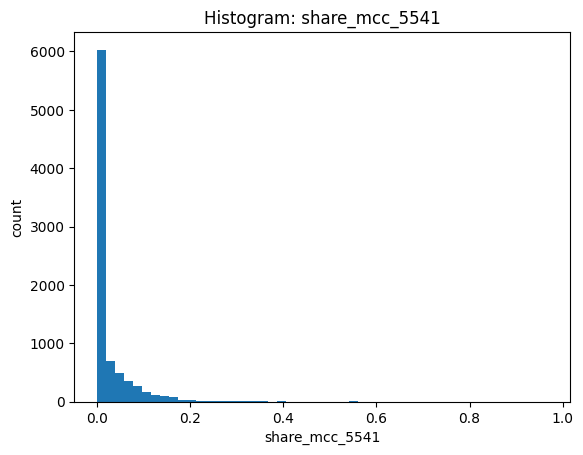

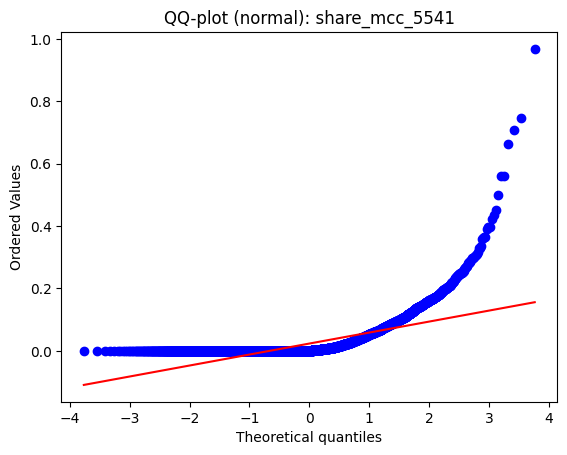

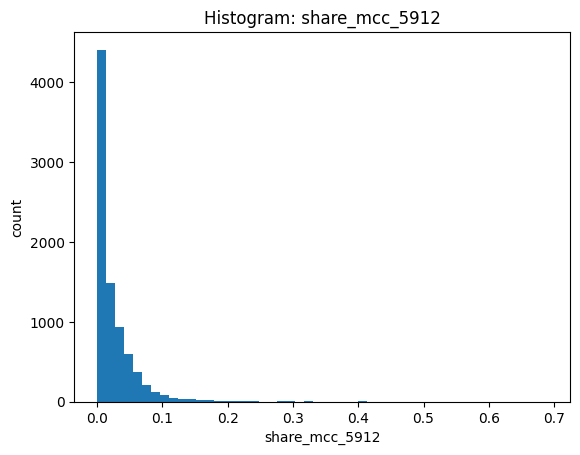

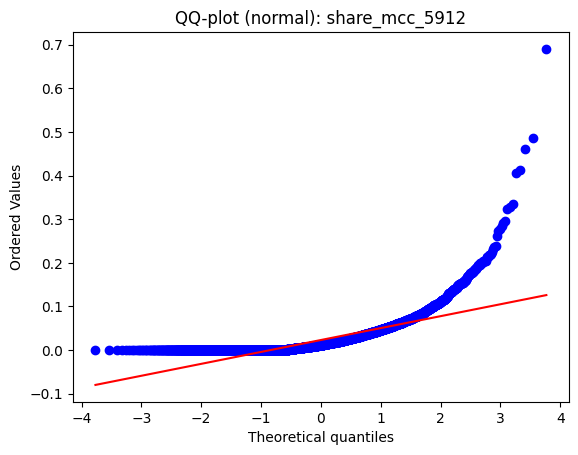

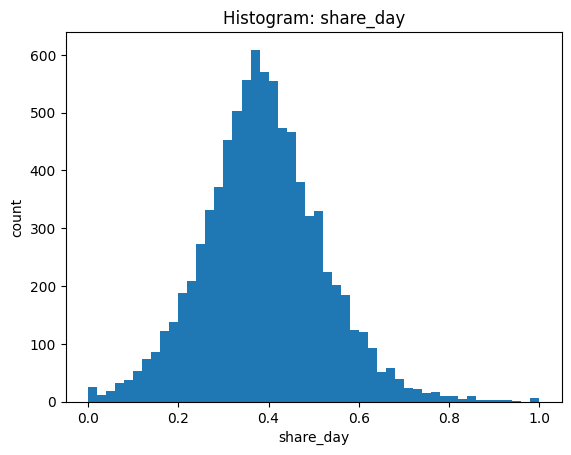

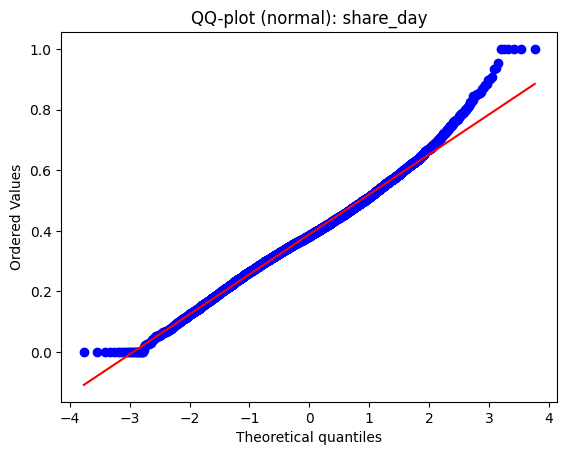

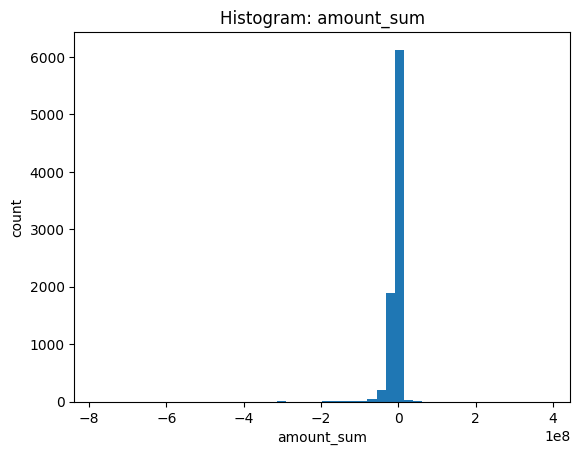

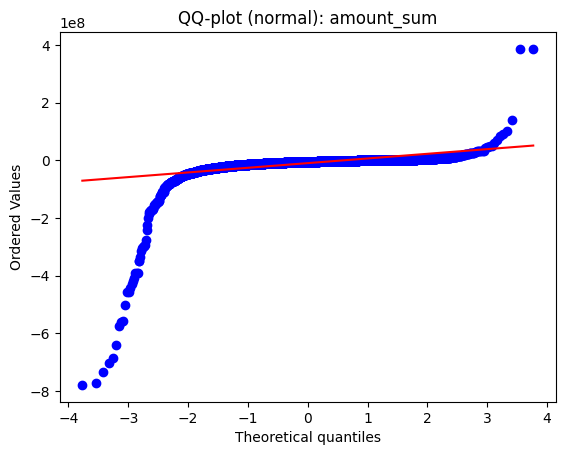

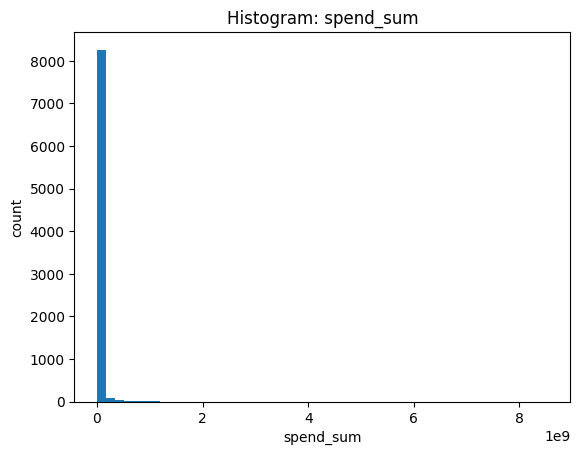

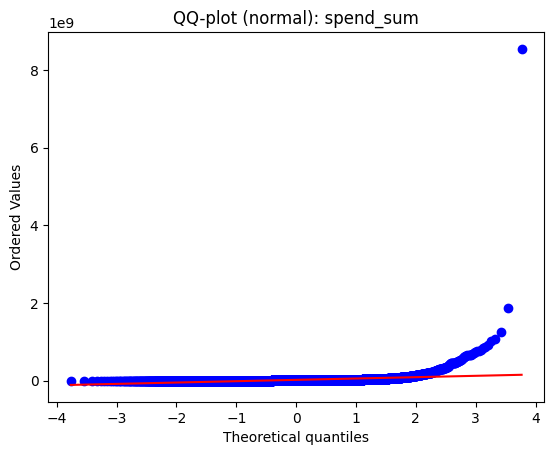

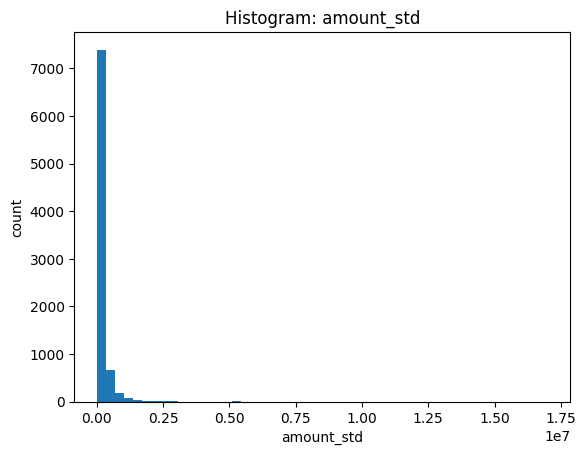

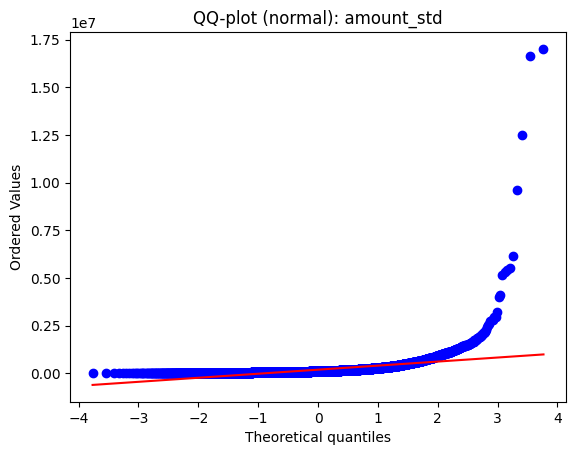

In [18]:
# =========================
# 1.3 — ЯЧЕЙКА 3 (Code)
# Цель: построить графики распределений для отчёта
# - histogram
# - QQ-plot
# Обычно делают для 6–10 ключевых признаков
# =========================

import matplotlib.pyplot as plt
from scipy import stats

# ---------- НАСТРОЙКИ (МЕНЯТЬ НА СОРЕВНОВАНИИ) ----------
PLOT_TOP_N = 6   # <-- МЕНЯТЬ: сколько признаков рисовать в отчёте (обычно 6-12)

# Берём признаки по "силе эффекта" или по важности модели:
# Если есть TOP_FEATURES — отлично.
try:
    plot_features = TOP_FEATURES[:PLOT_TOP_N]
except NameError:
    plot_features = selected[:PLOT_TOP_N]

print("[OK] plot_features:", plot_features)

for col in plot_features:
    x = df_clients[col].dropna()

    # чтобы графики были быстрые и читабельные
    if len(x) > 20000:
        x = x.sample(20000, random_state=42)

    # 1) гистограмма
    plt.figure()
    plt.hist(x, bins=50)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.show()

    # 2) QQ-plot
    plt.figure()
    stats.probplot(x, dist="norm", plot=plt)
    plt.title(f"QQ-plot (normal): {col}")
    plt.show()

# Методы проверки нормальности.
Нормальность распределений числовых признаков оценивалась с использованием графических методов (гистограммы и QQ-графики) и статистических критериев (Shapiro–Wilk для выборок до 5000 наблюдений, D’Agostino K² и Anderson–Darling для более общих случаев). Дополнительно оценивались коэффициенты скошенности (skewness) и эксцесса (kurtosis).

# Обоснование выбора методов.
Графические методы позволяют оценить форму распределения и отклонения от нормальности визуально, а статистические критерии дают формальную проверку гипотезы о нормальности. Для больших объёмов данных статистические тесты часто чувствительны к малым отклонениям, поэтому результаты интерпретировались совместно с графиками и метриками скошенности.

# Выводы и трансформации.
Для признаков с выраженной скошенностью рекомендованы преобразования (log1p для неотрицательных признаков, либо Yeo–Johnson для признаков с отрицательными значениями). Для слабой/умеренной скошенности достаточно стандартизации или робастного масштабирования.

# Универсальная структура отчёта 1.4
1. Назначение и общий обзор решения
2. Описание реализованного функционала
3. Подходы к сбору и загрузке данных
4. Предобработка данных и построение признаков
5. Структура базы данных
6. Итоговые форматы данных
7. Примеры записей из датасета

# 1 Назначение и общий обзор решения

УНИВЕРСАЛЬНЫЙ ТЕКСТ

В рамках работы был разработан программный агент для автоматизированной загрузки, хранения и анализа данных.
Основной целью решения является формирование структурированного набора данных, пригодного для последующего машинного обучения и аналитических исследований.

Реализованное решение обеспечивает:
	•	автоматическую загрузку исходных данных;
	•	сохранение данных в реляционной базе данных;
	•	обновление информации при повторных запусках без дублирования;
	•	предобработку и агрегацию данных;
	•	формирование признаков и анализ их значимости.

 ГДЕ МЕНЯТЬ
	•	«машинного обучения» → если вдруг будет статистика / прогноз / кластеризация

⸻

# 2 Описание реализованного функционала

Реализованный функционал включает следующие этапы:
	1.	Автоматическая загрузка исходных файлов из заданной директории.
	2.	Проверка корректности структуры данных (наличие обязательных колонок, типы данных).
	3.	Загрузка данных в базу данных SQLite с механизмом защиты от дублирования записей.
	4.	Формирование событийной таблицы и справочных таблиц.
	5.	Агрегация данных на уровне сущности (клиента) и построение признаков.
	6.	Анализ распределений признаков и их статистических свойств.
	7.	Выделение наиболее значимых атрибутов для целевой переменной.

 ГДЕ МЕНЯТЬ
	•	«клиента» → пользователь / пациент / объект / устройство

⸻

# 3 Обоснование подходов к сбору и загрузке данных

Для хранения данных была выбрана реляционная база данных SQLite, так как она:
	•	не требует серверной инфраструктуры;
	•	обеспечивает надёжное хранение и целостность данных;
	•	удобна для локальной аналитической обработки и прототипирования.

Для предотвращения дублирования данных использован механизм уникальных ключей и хеширования записей, что позволяет безопасно обновлять базу данных при повторных запусках агента.

 ГДЕ МЕНЯТЬ
	•	SQLite → PostgreSQL / MySQL (если вдруг потребуется)

⸻

# 4 Предобработка данных и построение признаков

Предобработка данных включала:
	•	очистку и проверку пропусков;
	•	приведение типов данных;
	•	формирование агрегированных признаков;
	•	нормализацию относительных показателей.

Признаки формировались на уровне сущности (клиента) и включали:
	•	количественные характеристики активности;
	•	финансовые агрегаты;
	•	временные паттерны;
	•	долевые показатели по категориям и типам событий.

Такой подход позволяет устранить смещение, связанное с разным числом событий у разных объектов, и сформировать компактный аналитический набор данных.

 ГДЕ МЕНЯТЬ
	•	«финансовые» → медицинские / технические / поведенческие

⸻
# 5️ Структура базы данных

УНИВЕРСАЛЬНО (можно даже списком)

База данных включает следующие основные таблицы:
	•	events / transactions — таблица событий (операции, действия, измерения);
	•	target — таблица с целевой переменной;
	•	reference tables — справочные таблицы категорий и типов;

Таблицы связаны между собой по идентификатору сущности (customer_id).

 ГДЕ МЕНЯТЬ
	•	названия таблиц
	•	customer_id → user_id, patient_id, object_id

⸻

# 6 Форматы итоговых файлов

В процессе работы использовались и формировались следующие форматы данных:
	•	CSV — исходные наборы данных;
	•	SQLite (.db) — база данных для хранения и обновления информации;
	•	DataFrame (pandas) — промежуточные и итоговые аналитические наборы данных;

Итоговый набор признаков используется для статистического анализа и обучения моделей машинного обучения.

 ГДЕ МЕНЯТЬ
	•	форматы — если будет Parquet / Excel / JSON

⸻

# 7 Примеры записей из датасета

Ниже приведён пример записей из итогового набора данных:

customer_id | tx_count | amount_sum | share_day | mcc_nunique | gender
---------------------------------------------------------------
22899       | 234      | -629796.59 | 0.40      | 19          | 1
28753       | 294      | -26546282  | 0.37      | 21          | 0
